# 509 Final Project

## Rsolve dependencies

In [1]:
! pip install newsapi-python

## Globally import libraries

In [182]:
import numpy as np
import pandas as pd
import pymysql as mysql
import matplotlib.pyplot as plt
import os
import shutil
import re
import logging
import time
import zipfile
import requests
from bs4 import BeautifulSoup
import datetime
import re
import regex as rex
from collections import defaultdict, Counter
import random
import requests
from bs4 import BeautifulSoup

import sqlite3
import nltk
from string import punctuation
from nltk.corpus import stopwords
import re
import emoji
from nltk.metrics import ConfusionMatrix

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
## Depracated:
# from sklearn.metrics import plot_confusion_matrix
## New version:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
#import mysql.connector

# Set pandas global options
pd.options.display.max_rows = 17

Data Preprocessing Functions:

In [198]:
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}


# Stopwords - added the 'nan' to this to remove nulls:
# next step could be to add pronouns like she/her, he/him, etc.

sw = stopwords.words("english")
sw = sw + ['nan']

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

def remove_stop(tokens) :
    # modify this function to remove stopwords

    return[t for t in tokens if t not in sw]
 
def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    
    return([item.lower() for item in whitespace_pattern.split(text)])
    
def remove_url(text):
    return(re.sub(r'http\S+', '', text))

def remove_messy(text): # remove words that give away the source
    text1=re.sub(r'cnn*', '', text)
    text2=re.sub(r'fox*', '', text1)
    return(re.sub(r'\\n*', '', text2))

# two pipelines to either tokenize or simply remove punctuation
# and lowercase as we will need to extract feature words:

full_pipeline = [str.lower, remove_url, remove_messy, remove_punctuation, tokenize, remove_stop]
first_pipeline = [str.lower, remove_url, remove_messy, remove_punctuation]


def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)

In [99]:
def conv_features(text,fw) :
     feature_set=dict()
     for word in text.split():
          if word in fw:
               feature_set[word]=True
     return(feature_set)

In [2]:
today = datetime.date.today()
print(today)
print(type(today))

2023-06-03
<class 'datetime.date'>


## Connect to NewsAPI client

In [3]:
from newsapi import NewsApiClient

api_key = os.environ['NewsAPIKey']

# Init
newsapi = NewsApiClient(api_key=api_key)

## Pull article info from API

# /v2/top-headlines/sources
sources = newsapi.get_sources()
print(sources)

In [6]:
def news_api_urls(q=None,
                  s=None,
                  d_from='2023-05-01',
                  d_to='2023-05-31',
                  api_lst=[]):
    all_articles = newsapi.get_everything(q=q,
                                          sources=s,
                                          from_param=d_from,
                                          to=d_to,
                                          language='en',
                                          sort_by='relevancy',
                                          page=1)

    print(type(all_articles))
    print(all_articles)
    #print('Article list: ', all_articles['articles'])
    for article in all_articles['articles']:
        print('Source ID:', article['source']['id'])
        print('Source name:', article['source']['name'])
        print('Author:', article['author'])
        print('Title:', article['title'])
        print('URL:', article['url'])
        print('Publish date:', article['publishedAt'])
        print('Article text:', article['content'], '\n')

    # Create a list of tuples from the dictionary data
    source_data01 = [(a['source']['name'],
                      a['author'],
                      a['title'],
                      a['url'],
                      a['publishedAt'],
                      a['content'])
                     for a in all_articles['articles']]

    api_lst.extend(source_data01)
    #print(api_lst)
    print(len(api_lst))

## Connect to API to access URLs

### Set API filter parameters

In [298]:
# Citation comes from Allsides Media Bias Chart

source_lst = ['the-washington-post','cnn','fox-news','breitbart-news']


#date_lst = ['2023-05-30', '2023-05-20']

date_lst = ['2023-05-30']

# Comes from academci text (fill in citation from DF)
#q_word_lst = ['gender OR male OR female OR transgender', 'security AND (social OR national)',
#              'justice OR surveillance', 'healthcare OR "health care"',
#              '(political AND (bias OR party)) OR republican OR democrat OR election', '(policy AND (drug OR "affirmative action")) OR regulate OR regulation']


#date_lst = ['2023-05-20', '2023-05-21', '2023-05-22', '2023-05-23', '2023-05-24', '2023-05-25',
#            '2023-05-26', '2023-05-27', '2023-05-28', '2023-05-29', '2023-05-31']

q_word_lst = ['justice OR surveillance', 'healthcare OR "health care"',
              '(political AND (bias OR party)) OR republican OR democrat OR election',
              'security AND (social OR national)']


### Access API

In [299]:
api_record_lst01 = []
for s in source_lst:
    print(f'Source: {s}')
    for d in date_lst:
        print(f'Date: {d}')
        for q in q_word_lst:
            print(f'Query word: {q}')
            time.sleep(5 + 11 * random.random())
            news_api_urls(q=q,
                          s=s,
                          d_from=d,
                          d_to=d,
                          api_lst=api_record_lst01)
            print(s, d, q)
    time.sleep(10 + 13 * random.random())

print(api_record_lst01)
print(len(api_record_lst01))

Source: the-washington-post
Date: 2023-05-30
Query word: justice OR surveillance
<class 'dict'>
{'status': 'ok', 'totalResults': 3, 'articles': [{'source': {'id': 'the-washington-post', 'name': 'The Washington Post'}, 'author': None, 'title': 'Alabama Highway sign hacked with white supremacist messages...', 'description': 'Alabama Highway sign hacked with white supremacist messages...\r\n\n \n \n \n (First column, 5th story, link)\r\n\n \r\n\n \r\n\n \n Related stories:Mob of up to 40 teens jump three marines on California beach...\r\nMemorial Day beatdown...\r\nVegas looks like warzone as massive…', 'url': 'https://www.washingtonpost.com/nation/2023/05/30/alabama-interstate-sign-white-supremacist-memorial-day/', 'urlToImage': 'https://img-s-msn-com.akamaized.net/tenant/amp/entityid/AA1bThEF.img?h=630&w=1200&m=6&q=60&o=t&l=f&f=jpg', 'publishedAt': '2023-05-30T16:31:36Z', 'content': 'Travelers in Alabama driving on Interstate 65 to parties and barbecues on Memorial Day might have seen m

Article data saved into dataframe:

In [307]:
api_record_df = pd.DataFrame (list (api_record_lst01),
                                   columns = ['Source','Author','Title','URL','date','content'])

FOX, CNN, Breitbert, and Washington Post:

In [308]:
article=[]

for index, rows in api_record_df.iterrows():
    article=[]
    url = api_record_df.at[index,'URL']
    response = requests.get(url)
    time.sleep(5 + 10*random.random())

    soup = BeautifulSoup(response.text, 'html.parser')
    #forcnn
    article_body = soup.find('div', class_='article__content-container')
    
    if article_body is None: #forfoxandbreitbert(sometimes)
        article_body = soup.find('p', class_="speakable")
        if article_body is None: #breitbert(most)
            article_body = soup.find('div', class_='entry-content')
            if article_body is None: #WashPost
                article_body = soup.find('div',class_='article-body')
                #if article_body is None:
                #    break
                                         

    if article_body is not None:
        article_text = article_body.get_text()
        api_record_df.at[index,'full_text']=article_text



In [309]:
api_record_df['Source'].value_counts()

Fox News               84
Breitbart News         53
CNN                    37
The Washington Post    25
Name: Source, dtype: int64

In [310]:
api_record_df.isnull().sum()

Source       0
Author       2
Title        0
URL          0
date         0
content      0
full_text    2
dtype: int64

In [338]:
#api_record_df=api_record_df.dropna()

In [337]:
#api_record_df['Source'].value_counts()

Save dataframe to csv file:

In [336]:
api_record_df.to_csv("News_API_FOX_CNN_Breitbert_WAPOST_allcolumns.csv", sep=',')

In [312]:
api_record_df.head(84)

,Source,Author,Title,URL,date,content,full_text
0,The Washington Post,None,Alabama Highway sign hacked with white suprema...,https://www.washingtonpost.com/nation/2023/05/...,2023-05-30T16:31:36Z,Travelers in Alabama driving on Interstate 65 ...,Travelers in Alabama driving on Interstate 65 ...
1,The Washington Post,Amber Phillips,Breaking down the GOP investigation into the B...,https://www.washingtonpost.com/politics/2023/0...,2023-05-30T19:56:33Z,Comment on this story\r\nComment\r\nA federal ...,A federal prosecutor may be nearing a decision...
2,The Washington Post,David Ovalle,Appeals court paves way for Purdue Pharma opio...,https://www.washingtonpost.com/health/2023/05/...,2023-05-30T23:52:34Z,Comment on this story\r\nComment\r\nA federal ...,A federal appeals court Tuesday cleared the wa...
3,The Washington Post,MSN (The Washington Post),Striking TV Workers Explain What The Job’s Rea...,https://www.washingtonpost.com/arts-entertainm...,2023-05-30T16:03:00Z,The entertainment industrys fourth wall is cru...,The entertainment industry’s fourth wall is cr...
4,The Washington Post,Philip Bump,Trump pledges to win an immigration fight he d...,https://www.washingtonpost.com/politics/2023/0...,2023-05-30T18:30:47Z,Comment on this story\r\nComment\r\nSpeaking i...,"Speaking in Orlando in November 2015, Republic..."
...,...,...,...,...,...,...,...
79,Fox News,Yael Halon,"Jewish groups, allies demand CUNY Law lose fun...",https://www.foxnews.com/media/jewish-groups-al...,2023-05-30T09:00:45Z,Pro-Israel groups and Jewish allies are callin...,Pro-Israel groups and Jewish allies are callin...
80,Fox News,Teny Sahakian,‘Horrifying’ CUNY Law commencement speech ‘bla...,https://www.foxnews.com/media/horrifying-cuny-...,2023-05-30T16:00:26Z,A City University of New York (CUNY) professor...,A City University of New York (CUNY) professor...
81,Fox News,Associated Press,India's top wrestlers hold off on protest agai...,https://www.foxnews.com/world/indias-top-wrest...,2023-05-30T17:37:57Z,India's top wrestlers held off from throwing t...,India's top wrestlers held off from throwing t...
82,Fox News,Gregg Jarrett,Free speech rights survived epic challenge fro...,https://www.foxnews.com/opinion/free-speech-ri...,2023-05-30T08:00:46Z,This essay is adapted from Gregg Jarretts new ...,This essay is adapted from Gregg Jarrett’s new...


In [10]:
#api_record_lst01 = [(1, 1, 1), (2, 2, 2), (3, 3, 3), (1, 1, 1), (4, 4, 4), (3, 3, 3)]
#print(api_record_lst01)
api_record_set01 = set(api_record_lst01)
print(api_record_set01)
api_record_lst02 = list(api_record_set01)
print(api_record_lst02)
print(len(api_record_lst02))

{('Fox News', 'Lawrence Richard', "Texas legislature's first special session focusing on border security, cutting property taxes, Abbott reveals", 'https://www.foxnews.com/politics/texas-legislatures-first-special-session-focusing-border-security-cutting-property-taxes-abbott-reveals', '2023-05-30T06:00:33Z', "Texas Gov. Greg Abbott revealed agenda items for the state legislature's first special session late Monday evening a list that includes cutting property taxes and providing funds to secure the U.S.-M… [+2386 chars]"), ('Fox News', 'Paul Steinhauser', 'Potential 2024 Republican presidential contender moves a step closer to launching a campaign', 'https://www.foxnews.com/politics/potential-2024-republican-presidential-contender-moves-step-closer-launching-campaign', '2023-05-30T15:25:48Z', 'Long-time supporters and allies of former New Jersey Gov. Chris Christie are launching a super PAC to back his likely campaign for the 2024 Republican presidential nomination, Fox News has confi

Create feature word set based on common words in dataset:

In [313]:
# Tokenize text:

api_record_df['tokens']= api_record_df['full_text'].apply(prepare,
                                                     pipeline=full_pipeline)

In [314]:
# Clean data into lowercase/no punctuation:

api_record_df['cleaner_text']= api_record_df['full_text'].apply(prepare,
                                                     pipeline=first_pipeline)

In [315]:
# Add target variable values:

api_record_df['Political_Lean'] = np.where((api_record_df['Source'] == "CNN") | (api_record_df['Source'] == "The Washington Post"), 'Left', 'Right')

In [316]:
api_record_df.head(100)

,Source,Author,Title,URL,date,content,full_text,tokens,cleaner_text,Political_Lean
0,The Washington Post,None,Alabama Highway sign hacked with white suprema...,https://www.washingtonpost.com/nation/2023/05/...,2023-05-30T16:31:36Z,Travelers in Alabama driving on Interstate 65 ...,Travelers in Alabama driving on Interstate 65 ...,"[travelers, alabama, driving, interstate, 65, ...",travelers in alabama driving on interstate 65 ...,Left
1,The Washington Post,Amber Phillips,Breaking down the GOP investigation into the B...,https://www.washingtonpost.com/politics/2023/0...,2023-05-30T19:56:33Z,Comment on this story\r\nComment\r\nA federal ...,A federal prosecutor may be nearing a decision...,"[federal, prosecutor, may, nearing, decision, ...",a federal prosecutor may be nearing a decision...,Left
2,The Washington Post,David Ovalle,Appeals court paves way for Purdue Pharma opio...,https://www.washingtonpost.com/health/2023/05/...,2023-05-30T23:52:34Z,Comment on this story\r\nComment\r\nA federal ...,A federal appeals court Tuesday cleared the wa...,"[federal, appeals, court, tuesday, cleared, wa...",a federal appeals court tuesday cleared the wa...,Left
3,The Washington Post,MSN (The Washington Post),Striking TV Workers Explain What The Job’s Rea...,https://www.washingtonpost.com/arts-entertainm...,2023-05-30T16:03:00Z,The entertainment industrys fourth wall is cru...,The entertainment industry’s fourth wall is cr...,"[entertainment, industry’s, urth, wall, crumbl...",the entertainment industry’s urth wall is crum...,Left
4,The Washington Post,Philip Bump,Trump pledges to win an immigration fight he d...,https://www.washingtonpost.com/politics/2023/0...,2023-05-30T18:30:47Z,Comment on this story\r\nComment\r\nSpeaking i...,"Speaking in Orlando in November 2015, Republic...","[speaking, orlando, november, 2015, republican...",speaking in orlando in november 2015 republica...,Left
...,...,...,...,...,...,...,...,...,...,...
95,Fox News,Yael Halon,DeSantis scorches 'totally inadequate' debt ce...,https://www.foxnews.com/media/desantis-scorche...,2023-05-30T21:50:51Z,Florida Governor and GOP presidential candidat...,Florida Governor and GOP presidential candidat...,"[florida, governor, gop, presidential, candida...",florida governor and gop presidential candidat...,Right
96,Fox News,"Rich Edson, Lawrence Richard",DeSantis to join 2024 Republican competitors a...,https://www.foxnews.com/politics/desantis-join...,2023-05-30T10:00:14Z,Florida Gov. Ron DeSantis will join several ot...,Florida Gov. Ron DeSantis will join several ot...,"[florida, gov, ron, desantis, join, several, d...",florida gov ron desantis will join several oth...,Right
97,Fox News,"Michael Ruiz, Ashley Papa",Eunice Dwumfour murder: New Jersey police make...,https://www.foxnews.com/us/eunice-dwumfour-mur...,2023-05-30T20:37:15Z,New Jersey authorities have arrested a 28-year...,New Jersey authorities have arrested a 28-year...,"[new, jersey, authorities, arrested, 28yearold...",new jersey authorities have arrested a 28yearo...,Right
98,Fox News,Hanna Panreck,MSNBC host boldly says DeSantis 'even money' t...,https://www.foxnews.com/media/msnbc-host-boldl...,2023-05-30T16:41:06Z,MSNBC host Joe Scarborough said Tuesday that G...,MSNBC host Joe Scarborough said Tuesday that G...,"[msnbc, host, joe, scarborough, said, tuesday,...",msnbc host joe scarborough said tuesday that g...,Right


In [317]:
# Obtain total counts of words in the entire corpus:

word_dist=Counter([item for sublist in api_record_df['tokens'] 
                   for item in sublist])

Preparing data for classifier ingestion (as dictionary)

In [318]:
# generate the dict data to then be filtered through
# the filtered_words list:

news_data=dict()

    
news_data=[(api_record_df.at[index,'cleaner_text'],
            api_record_df.at[index,'Political_Lean']) for (index,row) in api_record_df.iterrows()]

Determine featureword set:

In [319]:
word_cutoff=5
feature_words2=[]
for word, count in word_dist.items() :
    #for convention_data_df['word_dist']
    if count > word_cutoff :
        feature_words2.append(word)
            
print(f"With a word cutoff of {word_cutoff}, we have {len(feature_words2)} as features in the model.")

With a word cutoff of 5, we have 1710 as features in the model.


In [155]:
#feature_words2

In [324]:
# remove cnn and fox-news from the key featurewords:

#feature_words2.remove("cnn")
#feature_words2.remove("fox")
#feature_words2.remove("wpost")
#feature_words2.remove("breitbart")


In [325]:
# Filter the data through the feature words set
# determined above:

featuresets=dict()
featuresets = [(conv_features(text,feature_words2), 
                lean) for (text, lean) in news_data]

In [156]:
#featuresets

Rough Naive-Bayes Classifier setup and run-through:

In [326]:
random.seed(42)
random.shuffle(featuresets)
test_size = 20


In [327]:
test_set=dict()
train_set=dict()
test_set, train_set = featuresets[:test_size], featuresets[test_size:]

In [328]:
classifier = nltk.NaiveBayesClassifier.train(train_set)
print(nltk.classify.accuracy(classifier, test_set))

0.45


In [329]:
# Confusion Matrix:

predicted_labels = [classifier.classify(features) for features, 
                    label in test_set]
gold_labels = [label for features, label in test_set]

cm = ConfusionMatrix(gold_labels, predicted_labels)
print(cm.pretty_format(sort_by_count=True, show_percents=True))

      |      R        |
      |      i      L |
      |      g      e |
      |      h      f |
      |      t      t |
------+---------------+
Right | <10.0%> 55.0% |
 Left |      . <35.0%>|
------+---------------+
(row = reference; col = test)



SVM implementation:

In [330]:
X_train, X_test, Y_train, Y_test = train_test_split(api_record_df['cleaner_text'],
                                                    api_record_df['Political_Lean'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=api_record_df['Political_Lean'])

print('Size of Training Data ', X_train.shape[0])
print('Size of Test Data ', X_test.shape[0])

Size of Training Data  159
Size of Test Data  40


In [331]:
tfidf = TfidfVectorizer(min_df = 10, ngram_range=(1,2), stop_words="english")
X_train_tf = tfidf.fit_transform(X_train)

In [332]:
model1 = LinearSVC(random_state=0, tol=1e-5)
model1.fit(X_train_tf, Y_train)

LinearSVC(random_state=0, tol=1e-05)

In [333]:
X_test_tf = tfidf.transform(X_test)

In [334]:
Y_pred = model1.predict(X_test_tf)
print ('Accuracy Score - ', accuracy_score(Y_test, Y_pred))

Accuracy Score -  0.875


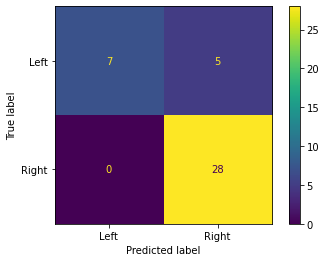

In [335]:
Y_pred = model1.predict(X_test_tf)
confusion_matrix(Y_test, Y_pred)
cm = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = model1.classes_)
disp.plot()
plt.show()

## Initiate MySQL connection

In [14]:
'''Set local environment variables to hide user name & password citation:
https://www.geeksforgeeks.org/how-to-hide-sensitive-credentials-using-python/'''

user_name = "sqluser"
user_pass = "password"

#user_name = os.environ['MySQLUSRAC']
#user_pass = os.environ['MySQLPWDAC']

# Instantiate connection
db_conn = mysql.connect(host='localhost',
                        port=int(3306),
                        user=user_name,
                        passwd=user_pass,
                        db='509_final_proj')

# Create a cursor object
cursor = db_conn.cursor()

In [15]:
tbl_names = pd.read_sql('SHOW TABLES', db_conn)

display(tbl_names)
print(type(tbl_names))

c:\Users\Susy\anaconda3\envs\humans\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,Tables_in_509_final_proj


<class 'pandas.core.frame.DataFrame'>


### Establish logging policy

In [20]:
'''Logging citations (see additional code in following code blocks:
OpenAI. (2021). ChatGPT [Computer software]. https://openai.com/;
https://docs.python.org/3/howto/logging.html#logging-basic-example;
https://docs.python.org/3/howto/logging.html#logging-to-a-file;
https://docs.python.org/3/howto/logging-cookbook.html#using-a-rotating-log-file-handler;
https://docs.python.org/3/howto/logging-cookbook.html#using-a-timed-rotating-file-handler'''

# Set up logging
logging.basicConfig(level=logging.INFO,
                    filename='pymysql.log',
                    filemode='a',
                    format='>>>>>>>>>>>>>><<<<<<<<<<<<<<\n%(asctime)s - %(levelname)s - %(message)s')

### Update individual tables

#### Update `news_articles` table from API

In [21]:
nat_tbl_name = 'nar_temp'
nwa_tbl_name = 'news_articles'

In [22]:
'''Using cursor and loading into temp file:
OpenAI. (2021). ChatGPT [Computer software]. https://openai.com/;
https://pynative.com/python-mysql-insert-data-into-database-table/'''

# Execute query and measure execution time
start_time = time.time()

# Wipe temp table
try:
    nat_dlt_tble_stmnt = f"""DELETE FROM {nat_tbl_name}"""
    cursor.execute(nat_dlt_tble_stmnt)
    logging.info(f'Successfully executed query:\n{nat_dlt_tble_stmnt}\n\nRecords scanned: {cursor.rowcount}')
except mysql.Error as e:
    logging.error(f'Error executing query:\n{nat_dlt_tble_stmnt}\n\n{e}')
finally:
    end_time = time.time()
    logging.info(f'Time taken: {end_time - start_time:.3f} seconds\n>>>>>>>>>>>>>><<<<<<<<<<<<<<\n\n')

# Execute query and measure execution time
start_time = time.time()

# Load data from CSV file into a temporary table
try:
    nat_csv_load_stmnt = f"""
    INSERT INTO {nat_tbl_name}
    (
    source_name,
    author,
    title,
    url,
    publish_date,
    content
    )
    VALUES (%s, %s, %s, %s, %s, %s)
    """

    # Execute the query with multiple values
    cursor.executemany(nat_csv_load_stmnt, api_record_lst02)
    #cursor.execute(nat_csv_load_stmnt)
    logging.info(f'Successfully executed query:\n{nat_csv_load_stmnt}\n\nRecords scanned: {cursor.rowcount}')
except mysql.Error as e:
    logging.error(f'Error executing query:\n{nat_csv_load_stmnt}\n\n{e}')
finally:
    end_time = time.time()
    logging.info(f'Time taken: {end_time - start_time:.3f} seconds\n>>>>>>>>>>>>>><<<<<<<<<<<<<<\n\n')

# Execute query and measure execution time
start_time = time.time()

# Insert new records into main table
try:
    nwa_load_stmnt = f"""
    INSERT INTO {nwa_tbl_name}
    (
    source_name,
    author,
    title,
    url,
    publish_date,
    content
    )
    SELECT
        tp.source_name,
        tp.author,
        tp.title,
        tp.url,
        tp.publish_date,
        tp.content
    FROM {nat_tbl_name} AS tp
    LEFT JOIN {nwa_tbl_name} AS mn
        ON tp.title = mn.title
            AND CAST(LEFT(tp.publish_date, 10) AS DATE) = CAST(LEFT(mn.publish_date, 10) AS DATE)
            AND tp.author = mn.author
    """
    cursor.execute(nwa_load_stmnt)
    logging.info(f'Successfully executed query:\n{nwa_load_stmnt}\n\nRecords scanned: {cursor.rowcount}')
except mysql.Error as e:
    logging.error(f'Error executing query:\n{nwa_load_stmnt}\n\n{e}')
finally:
    end_time = time.time()
    logging.info(f'Time taken: {end_time - start_time:.3f} seconds\n>>>>>>>>>>>>>><<<<<<<<<<<<<<\n\n')

# Execute query and measure execution time
start_time = time.time()

# Wipe temp table
try:
    cursor.execute(nat_dlt_tble_stmnt)
    logging.info(f'Successfully executed query:\n{nat_dlt_tble_stmnt}\n\nRecords scanned: {cursor.rowcount}')
except mysql.Error as e:
    logging.error(f'Error executing query:\n{nat_dlt_tble_stmnt}\n\n{e}')
finally:
    end_time = time.time()
    logging.info(f'Time taken: {end_time - start_time:.3f} seconds\n>>>>>>>>>>>>>><<<<<<<<<<<<<<\n\n')

### Commit changes and close cursor and connection instances

In [23]:
# Commit the changes to the database
db_conn.commit()

# Close the cursor and database connection
cursor.close()
db_conn.close()